In [ ]:
import os
import shutil

# Translate Italian to English
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant",
    "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
    "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"
}

raw_dir = "/kaggle/input/animals10/raw-img"
renamed_dir = "/kaggle/working/renamed-img"
os.makedirs(renamed_dir, exist_ok=True)

# Copy and rename class folders
for italian_name in os.listdir(raw_dir):
    english_name = translate.get(italian_name, italian_name)
    shutil.copytree(
        os.path.join(raw_dir, italian_name),
        os.path.join(renamed_dir, english_name)
    )

print("Renamed folders and copied to working directory.")


In [ ]:
# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor


2025-05-31 12:39:29.776528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748695170.007368      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748695170.089390      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import random
from tqdm import tqdm

split_base = "/kaggle/working/Animal_Dataset_Split"
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Create split folders
for split in ['train', 'val', 'test']:
    for category in os.listdir(renamed_dir):
        os.makedirs(os.path.join(split_base, split, category), exist_ok=True)

# Shuffle and copy images
for category in tqdm(os.listdir(renamed_dir)):
    img_list = os.listdir(os.path.join(renamed_dir, category))
    random.shuffle(img_list)

    n_total = len(img_list)
    n_train = int(n_total * split_ratio['train'])
    n_val = int(n_total * split_ratio['val'])

    train_imgs = img_list[:n_train]
    val_imgs = img_list[n_train:n_train+n_val]
    test_imgs = img_list[n_train+n_val:]

    for img in train_imgs:
        shutil.copy(os.path.join(renamed_dir, category, img),
                    os.path.join(split_base, 'train', category, img))
    for img in val_imgs:
        shutil.copy(os.path.join(renamed_dir, category, img),
                    os.path.join(split_base, 'val', category, img))
    for img in test_imgs:
        shutil.copy(os.path.join(renamed_dir, category, img),
                    os.path.join(split_base, 'test', category, img))


100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


In [5]:
import os

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_base, split)
    print(f"\n{split} contains:")
    for category in os.listdir(split_path):
        category_path = os.path.join(split_path, category)
        num_files = len(os.listdir(category_path))
        print(f"  {category}: {num_files} images")



train contains:
  horse: 2377 images
  sheep: 1639 images
  squirrel: 1682 images
  dog: 4393 images
  butterfly: 1915 images
  chicken: 2819 images
  spider: 4365 images
  elephant: 1325 images
  cat: 1546 images
  cow: 1679 images

val contains:
  horse: 718 images
  sheep: 503 images
  squirrel: 517 images
  dog: 1339 images
  butterfly: 576 images
  chicken: 864 images
  spider: 1337 images
  elephant: 401 images
  cat: 468 images
  cow: 506 images

test contains:
  horse: 731 images
  sheep: 504 images
  squirrel: 517 images
  dog: 1356 images
  butterfly: 598 images
  chicken: 860 images
  spider: 1333 images
  elephant: 415 images
  cat: 479 images
  cow: 523 images


# **Images Preprocessing**
Scaling and fixing pixel sizes

In [4]:
#No re executing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Define paths FIRST
original_dataset_dir = "/content/drive/MyDrive/Animal_Dataset/raw-img"
base_dir = "/content/drive/MyDrive/Animal_Dataset_Split"
train_generator = train_datagen.flow_from_directory(
    base_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    base_dir + '/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    base_dir + '/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct evaluation
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Animal_Dataset_Split/train'

# **Pytorch + Hugging Face Implementation**

In [ ]:
!pip install torch torchvision transformers datasets

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transform

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# Paths on Kaggle (assuming you placed the split dataset here)
train_path = "/kaggle/working/Animal_Dataset_Split/train"
val_path = "/kaggle/working/Animal_Dataset_Split/val"
test_path = "/kaggle/working/Animal_Dataset_Split/test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 23740
Validation samples: 7229
Test samples: 7316


In [7]:
import torch
from transformers import ViTForImageClassification

# Number of classes
num_classes = len(train_dataset.classes)
print(f"Number of Classes: {num_classes}")

# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded successfully on", device)

#dk


# Make sure model is on the correct device
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)  # AdamW is better for Transformers
criterion = nn.CrossEntropyLoss()


Number of Classes: 10


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully on cuda


In [22]:
import cv2

def clean_corrupted_images(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                file_path = os.path.join(root, file)
                try:
                    # Attempt to load with OpenCV
                    img = cv2.imread(file_path)
                    if img is None:
                        raise Exception("Image could not be loaded")
                except Exception as e:
                    print(f"Removing corrupted file: {file_path}")
                    os.remove(file_path)
# Run once:

clean_corrupted_images('/kaggle/working/Animal_Dataset_Split/train')
clean_corrupted_images('/kaggle/working/Animal_Dataset_Split/val')
clean_corrupted_images('/kaggle/working/Animal_Dataset_Split/test')
#Re run train loader after this


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

# Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store training/validation stats
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
true_labels = []     # All true labels over validation
predictions = []     # All predictions over validation

# Move model to the correct device
model = model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Optional: learning rate scheduler (uncomment if needed)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Number of epochs
num_epochs = 12

# --- Training Loop ---
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits  # for ViT or HF models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total
    val_epoch_precision = precision_score(all_labels, all_preds, average='macro')
    val_epoch_recall = recall_score(all_labels, all_preds, average='macro')
    val_epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_epoch_precision)
    val_recalls.append(val_epoch_recall)
    val_f1s.append(val_epoch_f1)

    # Save predictions and true labels for this epoch
    true_labels.extend(all_labels)
    predictions.extend(all_preds)

    print(f"Val Loss: {val_epoch_loss:.4f} | Val Accuracy: {val_epoch_acc:.2f}%")
    print(f"Val Precision: {val_epoch_precision:.4f} | Recall: {val_epoch_recall:.4f} | F1-Score: {val_epoch_f1:.4f}\n")

   #scheduler.step() if using a scheduler


Epoch 1/5
--------------------
Train Loss: 0.5704 | Train Accuracy: 93.08%
Val Loss: 0.1699 | Val Accuracy: 98.51%
Val Precision: 0.9849 | Recall: 0.9834 | F1-Score: 0.9841

Epoch 2/5
--------------------


# Saving Model and its stats for reloading.

In [ ]:
model.save_pretrained("saved_model_dir")


In [1]:
import os
import torch
import shutil
import json

# Define output directory
save_dir = "/kaggle/working/saved_model"
os.makedirs(save_dir, exist_ok=True)

# Save training and validation statistics + predictions
torch.save({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accuracies,
    'val_accs': val_accuracies,
    'val_precisions': val_precisions,
    'val_recalls': val_recalls,
    'val_f1s': val_f1s,
    'true_labels': true_labels,
    'predictions': predictions,
    'class_to_idx': train_dataset.class_to_idx  # Saving the class mapping
}, os.path.join(save_dir, 'training_stats.pth'))

# Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, 'animal_classifier_k.pth'))

# Save class-to-index mapping separately as JSON
with open(os.path.join(save_dir, 'class_to_idx.json'), 'w') as f:
    json.dump(train_dataset.class_to_idx, f)

# Zip everything for download
shutil.make_archive("/kaggle/working/animal_model_bundle", 'zip', save_dir)

print("Model, stats, and class labels saved and zipped for download.")


NameError: name 'train_losses' is not defined

In [ ]:
# Trying to download the model file
from google.colab import files
files.download('/kaggle/working/animal_model_bundle.zip')


In [ ]:
from IPython.display import FileLink

FileLink('/kaggle/working/animal_model_bundle.zip')


In [ ]:
import os
os.rename('/kaggle/working/animal_model_bundle.zip', '/kaggle/working/model.zip')


In [ ]:
FileLink('/kaggle/working/model.zip')


In [ ]:
import os
print(os.listdir('/kaggle/working'))


## Initializing Model


In [6]:
# Initialize the saved model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",  # Pretrained ViT model
    num_labels=10,  # Set number of classes based on your dataset
    ignore_mismatched_sizes=True
)

# Load the saved weights into the model
model.load_state_dict(torch.load('/kaggle/input/wildlifespeciedetector/other/default/1/animal_classifier_k.pth'))

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


# **Testing**

In [26]:
# Set the model to evaluation mode
model.eval()

# Variables to track loss and accuracy
test_loss = 0.0
test_correct = 0
test_total = 0

# Disable gradient calculations since we are in evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        # Update accuracy
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0912
Test Accuracy: 97.79%


# Image Prediction

In [11]:
from PIL import Image
import torch
from torchvision import transforms
import json

# Load class names from JSON file
with open('/kaggle/input/wildlifespeciedetector/other/default/1/class_to_idx.json', 'r') as f:
    class_to_idx = json.load(f)

# Get class names ordered by index
class_names = [None] * len(class_to_idx)
for class_name, idx in class_to_idx.items():
    class_names[idx] = class_name


# Define the transformation used during training (resize, normalize, and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Function to predict the class of an image
def predict_image(image_path, model, class_names):
    # Open the image
    image = Image.open(image_path)

    # Apply the same transformations that were applied during training
    image = transform(image).unsqueeze(0)  # Add a batch dimension

    # Move the image to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)

    # Put the model in evaluation mode and make the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image).logits  # ViTForImageClassification returns a dict-like output
        _, predicted_class = torch.max(outputs, 1)  # Get the class with the highest score

    # Convert the predicted class to the actual label
    predicted_class = predicted_class.item()  # Get the integer class index
    predicted_label = class_names[predicted_class]  # Get the corresponding class name

    return predicted_label

# Example usage:
image_path = "/kaggle/input/animals10/raw-img/farfalla/OIP--ENWG-ez2NKhOnDxPMCeQAHaEA.jpeg"  # Replace with the path to your image
#class_names = train_dataset.classes  # List of class labels (from training dataset)

# Make a prediction
predicted_label = predict_image(image_path, model, class_names)
print(f"Predicted class: {predicted_label}")


['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Predicted class: butterfly


# Loss Curve (Training vs Validation Loss)

In [ ]:
import torch
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Load the saved statistics and class mappings
stats = torch.load('/kaggle/input/wildlifespeciedetector/other/default/1/training_stats.pth')  # Update path
with open('/kaggle/input/wildlifespeciedetector/other/default/1/class_to_idx.json') as f:  # Update path
    class_to_idx = json.load(f)

# Convert class mapping to list for proper ordering
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]

# 2. Extract metrics from stats
train_losses = stats['train_losses']
val_losses = stats['val_losses']
all_true_labels = stats['true_labels']
all_preds = stats['predictions']

# 3. Create the visualization figure
plt.figure(figsize=(18, 6))

# Plot training/validation curves
plt.subplot(1, 2, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)

# Add accuracy curves if available
if 'train_accuracies' in stats and 'val_accuracies' in stats:
    plt.twinx()
    plt.plot(epochs, stats['train_accuracies'], 'b--', label='Training Accuracy', alpha=0.7)
    plt.plot(epochs, stats['val_accuracies'], 'r--', label='Validation Accuracy', alpha=0.7)
    plt.ylabel('Accuracy (%)')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Metrics', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot confusion matrix with class names
plt.subplot(1, 2, 2)
cm = confusion_matrix(all_true_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=plt.gca(), values_format='d', colorbar=False)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add overall accuracy in the confusion matrix title
accuracy = 100 * (cm.diagonal().sum() / cm.sum())
plt.title(f'Confusion Matrix (Overall Accuracy: {accuracy:.2f}%)', fontsize=14)
plt.savefig("accCurve.png", dpi=300, bbox_inches="tight")

plt.show()

In [13]:
# Assuming you have stored training and validation loss during training in lists
# You should have `train_losses` and `val_losses` for each epoch

import matplotlib.pyplot as plt

# Plot the loss curve
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.savefig("lossCurve.png", dpi=300, bbox_inches="tight")

plt.show()


NameError: name 'num_epochs' is not defined

# **Bar Chart**

# **LIME**

In [ ]:
!pip install lime

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

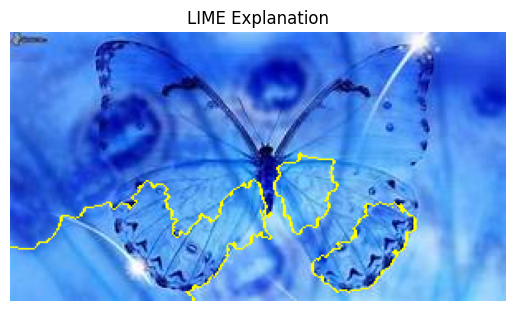

In [14]:
from transformers import ViTForImageClassification
import torch

# Load your trained ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()  # Set to evaluation mode

from lime import lime_image
from skimage.segmentation import mark_boundaries

# Initialize explainer
explainer = lime_image.LimeImageExplainer()

from PIL import Image


def vit_predict_fn(images):
    """Convert LIME's numpy array to ViT-compatible input"""
    inputs = torch.stack([transform(Image.fromarray(img)) for img in images])
    with torch.no_grad():
        outputs = model(inputs).logits
    return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

# Load test image
from matplotlib import pyplot as plt
test_image = Image.open("/kaggle/input/animals10/raw-img/farfalla/OIP--ENWG-ez2NKhOnDxPMCeQAHaEA.jpeg").convert("RGB")

# Explain prediction
explanation = explainer.explain_instance(
    np.array(test_image), 
    vit_predict_fn, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000  # Increase for better quality
)

# Get LIME explanation for top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Visualize
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.savefig("Lime1.png", dpi=300, bbox_inches="tight")

plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

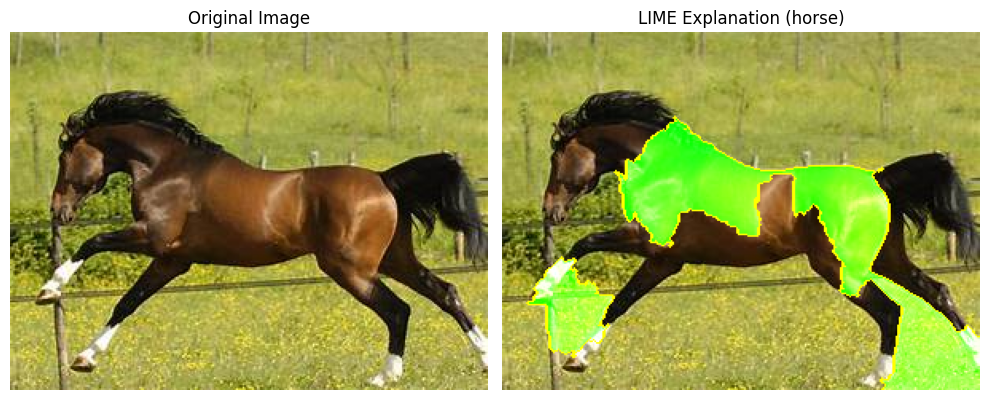


Prediction Probabilities:
butterfly: 0.03%
cat: 0.02%
chicken: 0.06%
cow: 0.09%
dog: 0.03%
elephant: 0.03%
horse: 99.65%
sheep: 0.03%
spider: 0.04%
squirrel: 0.03%


In [27]:
import numpy as np
import torch
from transformers import ViTForImageClassification, ViTConfig
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load ViT model config and initialize with correct number of classes
config = ViTConfig.from_pretrained("google/vit-base-patch16-224", num_labels=10)
model = ViTForImageClassification(config)

# 3. Load weights from your custom-trained model
weights_path = "/kaggle/input/wildlifespeciedetector/other/default/1/animal_classifier_k.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))
model = model.to(device)
model.eval()

# 4. Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 5. Prediction function for LIME
def vit_predict_fn(images):
    inputs = torch.stack([transform(Image.fromarray(img)) for img in images]).to(device)
    with torch.no_grad():
        outputs = model(inputs).logits
    return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

# 6. Initialize LIME explainer
explainer = lime_image.LimeImageExplainer(random_state=42)

# 7. Load and process test image
test_image_path = "/kaggle/input/animals10/raw-img/cavallo/OIP---MGqQIhmz3OEPYP-46_xwHaFj.jpeg"
test_image = Image.open(test_image_path).convert("RGB")

# 8. Generate explanation
explanation = explainer.explain_instance(
    np.array(test_image),
    vit_predict_fn,
    top_labels=3,
    hide_color=0,
    num_samples=1500,
    batch_size=32,
    random_seed=42
)

# 9. Visualize results
plt.figure(figsize=(10, 8))

label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=False,
    num_features=7,
    hide_rest=False,
    min_weight=0.01
)
class_names = [
    "butterfly", "cat", "chicken", "cow", "dog",
    "elephant", "horse", "sheep", "spider", "squirrel"
]
# Original image
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Original Image")
plt.axis('off')

# LIME Explanation
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation ({class_names[label]})")
plt.axis('off')

plt.tight_layout()
plt.savefig("Lime_Explanation.png", dpi=300, bbox_inches="tight")
plt.show()

# 10. Print prediction probabilities
probs = vit_predict_fn(np.expand_dims(np.array(test_image), 0))[0]
print("\nPrediction Probabilities:")
for i, prob in enumerate(probs):
    print(f"{class_names[i]}: {prob*100:.2f}%")


# **Confusion Matrix**

In [36]:
import torch
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm  # For progress bar

# 1. Load your model and class mappings
model = ...  # Load your trained ViT model here
model.eval()

with open('/kaggle/input/classifier/other/default/1/class_to_idx.json') as f:
    class_to_idx = json.load(f)
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]

# 2. Prepare to collect predictions
all_true_labels = []
all_preds = []

# 3. Run inference on test set
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        
        all_true_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 4. Calculate metrics
accuracy = np.mean(np.array(all_true_labels) == np.array(all_preds))
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# 5. Build confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_true_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    values_format="d",
    ax=plt.gca()
)

# Enhance visualization
plt.title(f"Confusion Matrix (Accuracy: {accuracy*100:.2f}%)", pad=20)
plt.xlabel("Predicted Label", labelpad=10)
plt.ylabel("True Label", labelpad=10)
plt.tight_layout()

# Save and show
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# 6. Save all stats for future use
torch.save({
    'true_labels': all_true_labels,
    'predictions': all_preds,
    'class_names': class_names,
    'accuracy': accuracy
}, 'test_results.pth')

AttributeError: 'ellipsis' object has no attribute 'eval'

Evaluating: 100%|██████████| 123/123 [01:01<00:00,  2.01it/s]


Test Accuracy: 98.04%


<Figure size 1200x1000 with 0 Axes>

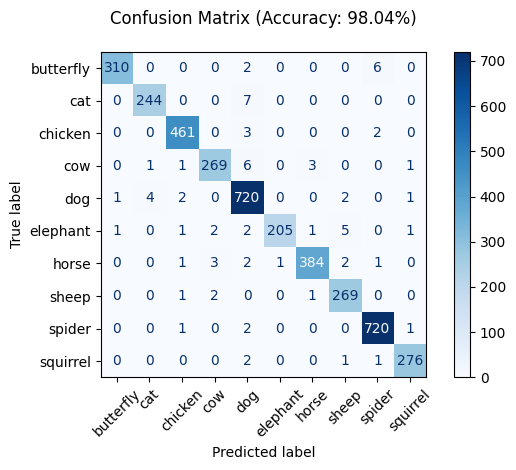

In [48]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTConfig

# 1. Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load model configuration and weights
config_path = "/kaggle/input/classifier/other/default/1/training_stats.pth"
weights_path = "/kaggle/input/classifier/other/default/1/animal_classifier_k.pth"

# Load config (assumed to be a dictionary saved with torch.save)
config_dict = torch.load(config_path, map_location='cpu')
config = ViTConfig(**config_dict)

# Load state dict
state_dict = torch.load(weights_path, map_location=device)

# Detect number of classes from classifier layer
num_classes = state_dict["classifier.weight"].shape[0]
config.num_labels = num_classes  # Update config

# Initialize model with correct number of labels
model = ViTForImageClassification(config)
model.classifier = torch.nn.Linear(config.hidden_size, num_classes)

# Load weights
model.load_state_dict(state_dict, strict=True)

# Move to device and eval mode
model = model.to(device)
model.eval()

# 3. Load class mappings
with open('/kaggle/input/classifier/other/default/1/class_to_idx.json') as f:
    class_to_idx = json.load(f)
class_names = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]

# 4. Run inference and build confusion matrix
all_true_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        all_true_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 5. Calculate and display metrics
accuracy = np.mean(np.array(all_true_labels) == np.array(all_preds))
print(f"Test Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_true_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title(f"Confusion Matrix (Accuracy: {accuracy*100:.2f}%)", pad=20)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
